In [1]:
import pandas as pd
import numpy as np

'''
Reduced features
'''
df_feats = pd.read_csv('reduced_data.csv')
df_labels = pd.read_csv('disorders.csv')['Depressed']

df_red = pd.concat([df_feats, df_labels], axis=1)
df_red_depr = df_red.loc[df_red['Depressed'] == 1].drop(['Depressed'], axis=1, inplace=False) # depressed 
df_red_not_depr = df_red.loc[df_red['Depressed'] == 0].drop(['Depressed'], axis=1, inplace=False) # not depressed 

red_depr = df_red_depr.get_values()
red_not_depr = df_red_not_depr.get_values()

In [2]:
'''
Original features
'''
df_patient = pd.read_csv('patient_info.csv')
df_disorders = pd.read_csv('disorders.csv')
df_questionnaire = pd.read_csv('questionnaire.csv')
df_base_concen = pd.read_csv('base_concen.csv')

df_patient = df_patient[['Age', 'Gender_id', 'race_id', 'location_id']]
df_disorders.drop(['Patient_ID', 'ADHD_Type'], axis=1, inplace=True)
df_questionnaire.drop(['Patient_ID', 'BSC_Respondent', 'GSC_Respondent', 'LDS_Respondent'], axis=1, inplace=True)
df_base_concen.drop(['Patient_ID', 'Baseline_header_id', 'Concentration_header_id'], axis=1, inplace=True)

df = pd.concat([df_patient, df_disorders, df_questionnaire, df_base_concen], axis=1)

df_depr = df.loc[df['Depressed'] == 1].drop(['Depressed'], axis=1, inplace=False) # depressed 
df_not_depr = df.loc[df['Depressed'] == 0].drop(['Depressed'], axis=1, inplace=False) # not depressed 

depr = df_depr.get_values()
not_depr = df_not_depr.get_values()

## Step 1: State assumptions

- We assume that depressed features are sampled according to: X<sub>i</sub> ∼<sup>iid</sup> F<sub>D</sub>, and not depressed features are sampled according to: X<sub>i</sub> ∼<sup>iid</sup> F<sub>ND</sub>, which is both an independent and identical assumption.

## Step 2: Check assumptions

For independent features, check that off diagonal covariance is approximately 0.


For identical features, check the optimal number of clusters and see if that is 1.

### Independent Features Assumption

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

###  Identical Features Assumption

In [4]:
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import Grid

def cluster_feats(X, k, title, feat_names):
    # Visualize the clustering result
    fig = plt.figure()
    fig.suptitle(title, fontsize=14, fontweight='bold')
    fig.set_size_inches(10, 4)
    plt.subplots_adjust(top=0.85)

    grid = Grid(fig, rect=111, nrows_ncols=(1, 2),
                axes_pad=0.5, label_mode='L',
                )
    
    for i, ax in enumerate(grid):
        # Fit the data
        data = X[i].T
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        # Get cluster labels and centroids
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        
        # Plot clusters
        for j in range(k):
            # Extract observations within each cluster
            ds = data[np.where(labels==j)]
            
            # Plot the observations with symbol o
            ax.plot(ds[:,0], ds[:,1], 'o')
            
            # Plot the centroids with simbol x
            lines = ax.plot(centroids[j,0], centroids[j,1], 'x')
            plt.setp(lines, ms=8.0)
            plt.setp(lines, mew=2.0)
            
            ax.set_title(feat_names[i])

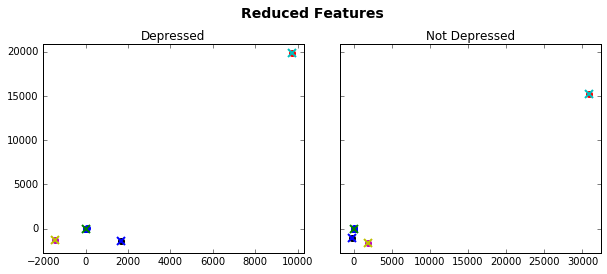

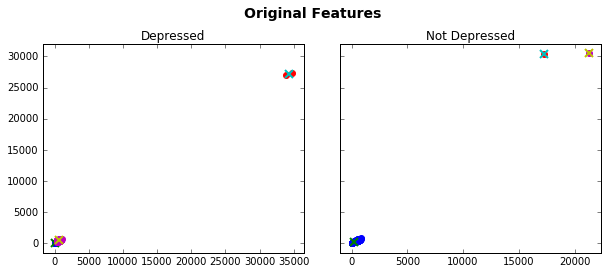

In [5]:
# Reduced Feature Clustering
red_feats = [red_depr, red_not_depr]
k = 4 # number of clusters
cluster_feats(red_feats, k, 'Reduced Features', ['Depressed', 'Not Depressed'])

# Original Feature Clustering
feats = [depr, not_depr]
k = 3 # number of clusters
cluster_feats(feats, k, 'Original Features', ['Depressed', 'Not Depressed'])

As shown in the figures above, the reduced depressed features and not depressed features are not identical and both fall into four clusters, while the original depressed features fall into two groups and original not depressed fall into three groups. Note that the reduced feature vector size is 27 and the original feature vector size is 737.

From above, we can conclude that our identical assumption is false.